In [1]:
import numpy as np
from skimage.io import imread
import flika as flk
import dask.array as da
import matplotlib.pyplot as plt
from dask.delayed import delayed
%matplotlib inline
flk.start_flika()

Starting flika


Starting flika inside IPython


In [3]:
data_r = imread('/groups/ahrens/ahrenslab/davis/anatomy/6dpf_cy331_f1_dv_1.lsm', plugin='tifffile').squeeze()

In [4]:
data_r.shape

(3, 60, 768, 768)

In [5]:
overlap_percent = 10
overlap = (data_r.shape[2] // overlap_percent)
data = np.hstack([np.squeeze(d[:,:,:-overlap]).transpose(0,2,1) for d in data_r])

In [6]:
data.shape

(60, 2076, 768)

In [7]:
# rescale the intensity of the lower planes to match the global max / min
from skimage.exposure import rescale_intensity as rescale
from functools import partial
out_range = data.min(), data.max()
rescaler = partial(rescale, out_range=out_range)
data_rescaled = da.from_array(data, chunks=(1, *data.shape[1:])).map_blocks(rescaler).compute()
data_rescaled = rescale(data_rescaled.astype('float'), out_range=(0,1))

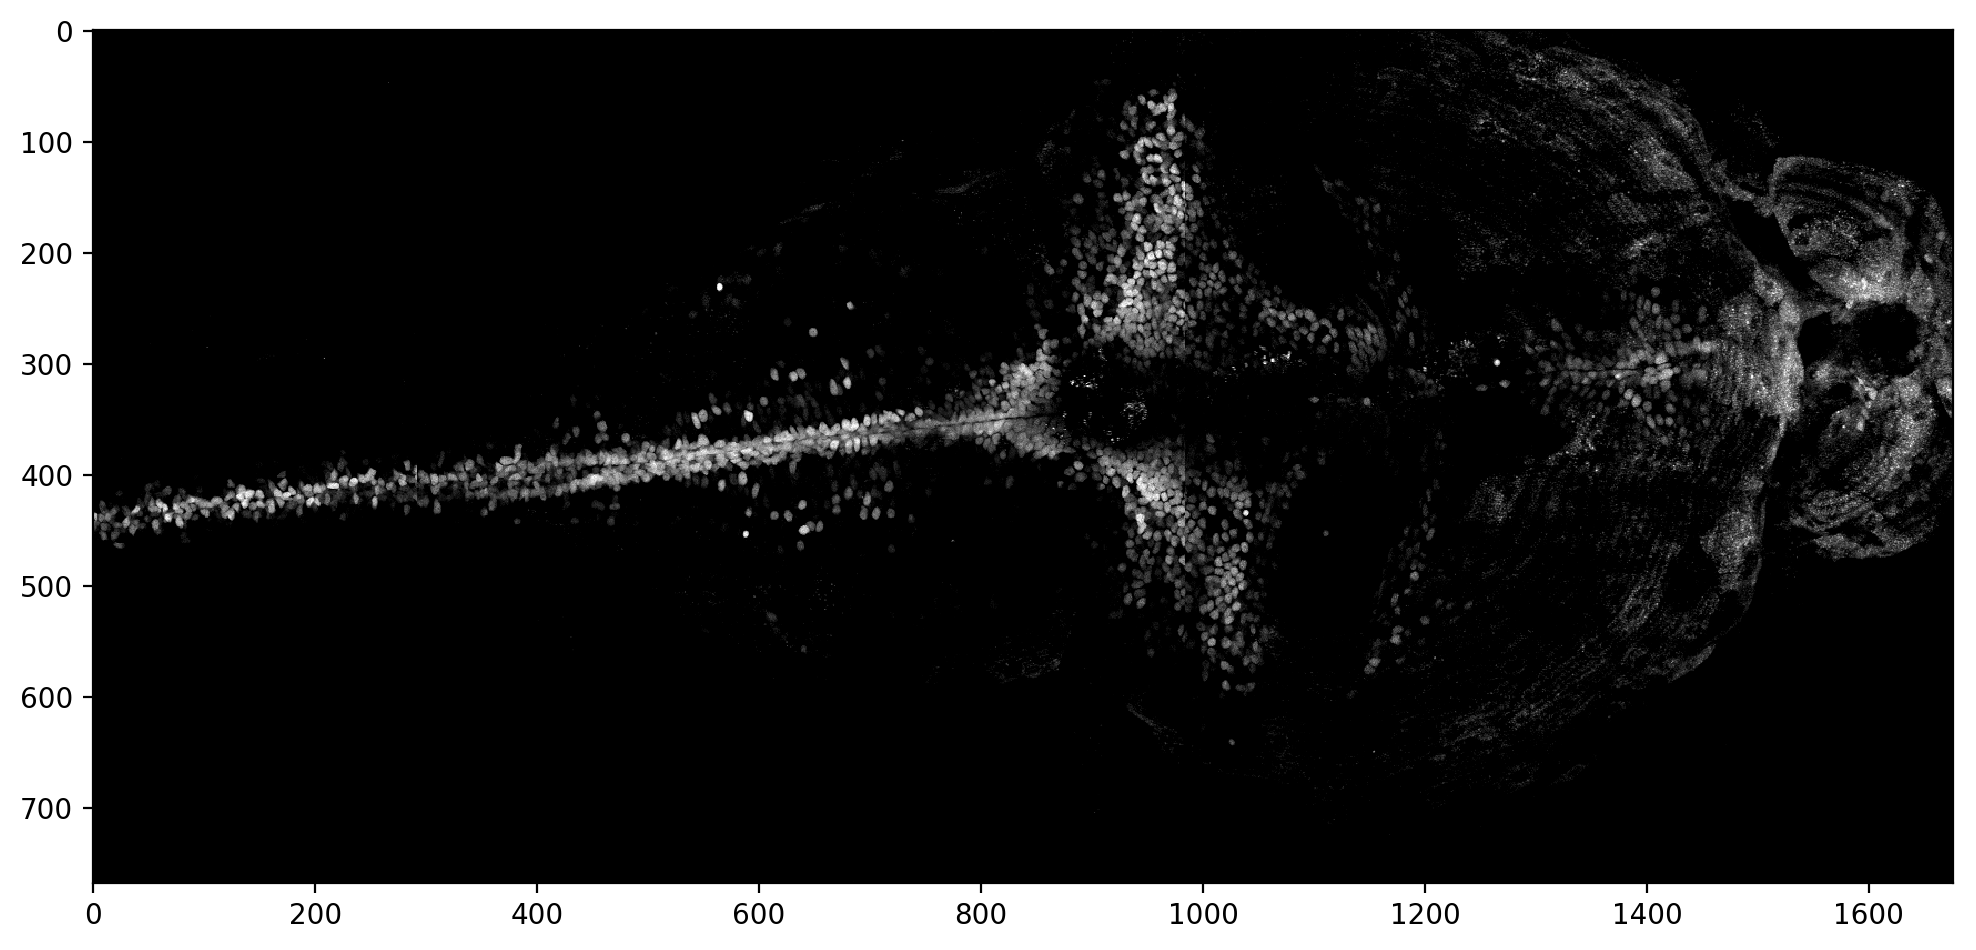

In [24]:
fig, axs = plt.subplots(ncols=1, figsize=(12,12), dpi=200)
crop = (slice(None), slice(400, None), slice(None))
axs.imshow(data_rescaled[crop].max(0).T, cmap='gray', clim=(.2,None))

In [25]:
# store the coordinates of some example cells
thr = .2
supra = (data_rescaled[crop] > thr).sum()
cell_vol = 49

print(supra / cell_vol * .9)
print(supra / cell_vol)
print(supra / cell_vol * 1.1)

8096.142857142858
8995.714285714286
9895.285714285716


[(0, 1676), (0, 1676), (0, 1676)]

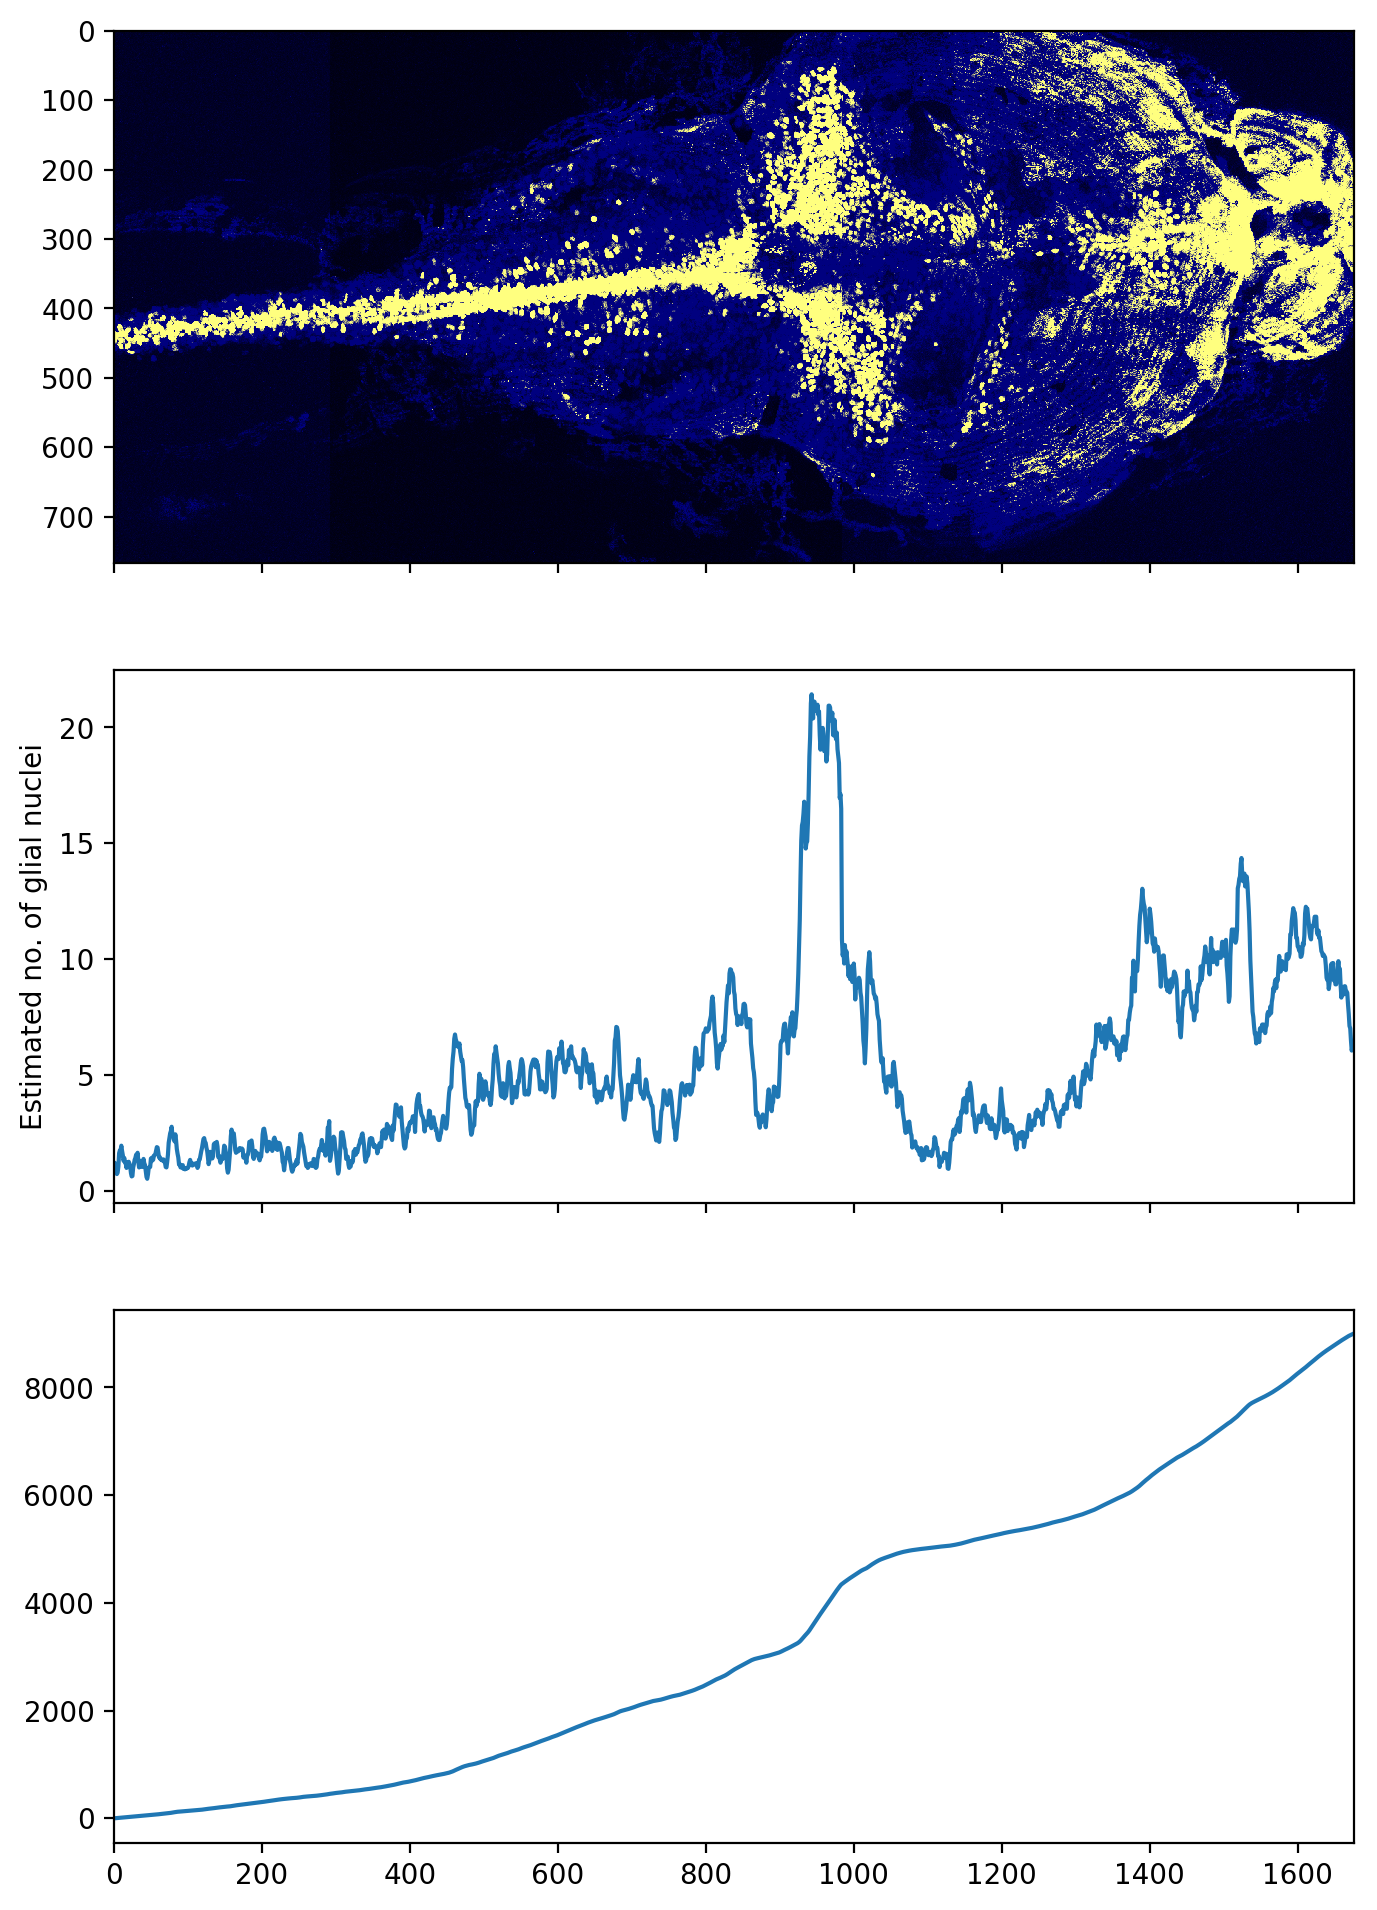

In [32]:
fig, axs = plt.subplots(nrows=3, sharex=True, dpi=200, figsize=(8,12))
from matplotlib.cm import gray,inferno
supra = gray(rescale(data_rescaled[crop].max(0).transpose(1,0), in_range=(thr,.3), out_range=(0,1)))
supra *= np.array([1,1,0,1])
sub = gray(rescale(data_rescaled[crop].max(0).transpose(1,0), in_range=(0,.1), out_range=(0,1)))
sub *= np.array([0,0,.5,1])
xlim = (0,data[crop].shape[1])
axs[0].imshow(supra + sub, aspect='auto')
axs[1].plot(((data_rescaled[crop] > thr).sum((0,2))/cell_vol))
axs[1].set_ylabel('Estimated no. of glial nuclei')
axs[2].plot(np.cumsum(((data_rescaled[crop] > thr).sum((0,2))/cell_vol)))
[ax.set_xlim(xlim) for ax in axs]

In [366]:
def get_pks(pln, thr=.18):
    from skimage.restoration import denoise_bilateral
    from skimage.feature import peak_local_max
    from skimage.exposure import rescale_intensity as rescale
    # rescale pln to [0,1]
    pln_r = rescale(pln.astype('float'), out_range=(0,1))
    pln_d = denoise_bilateral(pln_r, multichannel=False)
    pln_t = pln_d * (pln_d > thr)
    pks = peak_local_max(pln_t, min_distance=2)
    return pln_d, pks

In [197]:
%%time
from skimage.feature import peak_local_max
data_d = np.array(delayed([delayed(lambda v: denoise_bilateral(v, multichannel=False))(d) for d in data_rescaled]).compute())

CPU times: user 1min 49s, sys: 1min 3s, total: 2min 52s
Wall time: 1min 19s


In [510]:
from scipy.ndimage.filters import median_filter
data_d = median_filter(data_rescaled, size=(1,3,3))


In [509]:
flk.window.Window(data_d)

In [361]:
pks = peak_local_max(data_d * (data_d > .2), min_distance=1)

In [362]:
flk.window.Window(data_d * (data_d > .2))

In [ ]:
from skimage.segmentation import checkerboard_level_set, chan_vese
roi = (slice(20,21), slice(800,1600), slice(200,600))
tmp = (data_d * (data_d > .3))[roi].squeeze()
#tmp = data_d[roi].squeeze()
seg = chan_vese(tmp, max_iter=12000, lambda2=1.5, lambda1=1, mu=.001)

fig, axs = plt.subplots(figsize=(12,12))
axs.imshow(tmp)
axs.contour(seg)

In [789]:
#pk = 150
yr, xr=np.arange(-10,10), np.arange(-10,10).reshape(-1,1)
pks_windowed = np.array([data_d[roi].squeeze()[(yr + pk[0], xr + pk[1])] for pk in pks])
#plt.imshow(data_d[roi].squeeze()[yr + pks[pk][0], xr + pks[pk][1]])

In [721]:
flk.start_flika()

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [787]:
flk.window.Window(pks_windowed)

In [40]:
# try the same thing on some neuron data
data_n = imread('/groups/ahrens/ahrenslab/projects/ngm/anatomy/20141225/GAD_HucH2B_1_6d.lsm', plugin='tifffile').squeeze()[:,0]
data_n = np.array([rescale(d.astype('float'), out_range=(0,1)) for d in data_n])

In [41]:
data_n.shape

(329, 2048, 1024)

In [42]:
flk.window.Window(data_n)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


In [44]:
flk.window.Window(data_n.clip(.048, None))

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


In [665]:
cell_vol = (data_n > .048).sum()

In [706]:
cell_vol / (81 * 4)

140417.47222222222

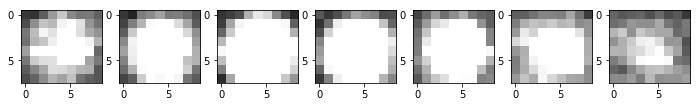

In [704]:
z_range = range(78,85)
x_range = slice(569, 578)
y_range = slice(1395, 1403)
fig, axs = plt.subplots(ncols=len(z_range), figsize=(12,12))
for ind, z in enumerate(z_range):
    axs[ind].imshow(data_n[z, y_range, x_range], cmap='gray', clim=(0,.3))

In [283]:
ball(3)[[1,3,5]]

array([[[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 1, 1, 1, 1, 1, 0],
        [0, 0, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]], dtype=uint8)

In [288]:
ball(2).shape

(5, 5, 5)

In [292]:
ball(2)[[0,2,0]]

array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]]], dtype=uint8)

In [298]:
ball(5).shape

(11, 11, 11)

In [311]:
len(np.where(masked_pts_thr)[0])

9118

In [ ]:
def cellcount(masked_img, selem)

In [ ]:
%%time
# implement tk's algorithm

from scipy.ndimage.filters import median_filter, rank_filter
from skimage.morphology import disk, ball
from skimage.filters import rank
from matplotlib.cm import gray
from skimage.morphology import skeletonize_3d

fig, axs = plt.subplots(dpi=200, ncols=5)
sample = data
thr = 600
z = 7
axs[0].imshow(sample[z])
mask = median_filter(sample, size=(2,3,3)) > thr
masked = sample * mask
axs[1].imshow(masked[z], cmap='gray', clim = (-10000,None))

selem = ball(5)[[0,5,0]]
rank_mx = rank_filter(masked, -1, footprint=selem)

axs[2].imshow(rank_mx[z])
masked_pts = skeletonize_3d(((rank_mx == masked) * mask).astype('float')).astype('float')
thr2 = 5000
masked_pts_thr = ((sample * masked_pts.astype('bool')) > thr2).astype('float')
axs[3].imshow(gray(masked_pts_thr)[z] * np.array([1,1,0,1]) + gray(rescale(sample.astype('float'), out_range=(0,1)))[z] * np.array([1,1,1,1]))
axs[4].imshow((rank_mx == masked)[z])

In [307]:
flk.window.Window(sample - 10000 * masked_pts_thr)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/pyqtgraph/imageview/ImageView.py:588: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = data[sl]


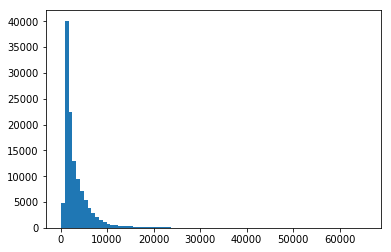

In [203]:
plt.hist(sample[masked_pts.astype('bool')], 80);

In [268]:
len(np.where(sample[masked_pts.astype('bool')] > 4000)[0])

14154

In [205]:
len(np.where(masked_pts)[0])

118555